In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cl2-assignment-8/euroSAT_train_val_test.pkl


In [2]:
#importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import numpy as np
import os
torch.manual_seed(22)

In [3]:
# Track currently selected GPU, and all CUDA tensors allocate will by default be created
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [4]:
#load the dataset
with open("../input/cl2-assignment-8/euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

In [5]:
#spliting the data into x_train, y_train, x_test, y_test, x_validation, y_validation
X_train = []
Y_train = []
X_test = []
Y_test = []
X_val = []
Y_val = []
for data in train_set:
    X_train.append(data[0])
    Y_train.append(data[1])
X_train = torch.from_numpy(np.array(X_train))
Y_train = torch.from_numpy(np.array(Y_train))
for data in test_set:
    X_test.append(data[0])
    Y_test.append(data[1])
X_test = torch.from_numpy(np.array(X_test))
Y_test = torch.from_numpy(np.array(Y_test))
for data in val_set:
    X_val.append(data[0])
    Y_val.append(data[1])
X_val = torch.from_numpy(np.array(X_val))
Y_val = torch.from_numpy(np.array(Y_val))

In [6]:
# initialize the train, validation, and test data loaders
load_train = DataLoader(torch.utils.data.TensorDataset(X_train,Y_train), batch_size = 100, shuffle = True)
load_test = DataLoader(torch.utils.data.TensorDataset(X_test, Y_test), batch_size = 100, shuffle = False)
load_valid = DataLoader(torch.utils.data.TensorDataset(X_val, Y_val), batch_size = 100, shuffle = False)

In [7]:
#Creating a CNN class
class Eurosat(nn.Module):
    # Determine what layers and their order in CNN object
    def __init__(self):
        super(Eurosat,self).__init__()
        # 1st convolutional layer with 64 out channels 
        # kernel size 3x3, stride 2, padding 1
        self.conv1 = nn.Conv2d(3,64,3,stride = 2, padding = 1)
        # relu activation
        self.relu = nn.ReLU()
        # max pooling with 2x2 subsampling
        self.maxpool1 = nn.MaxPool2d(2,stride = 2)
        # 2nd convolutional layer with 96 out channels 
        # kernel size 3x3, stride 2, padding 1
        self.conv2 = nn.Conv2d(64,96,3,padding = 1)
        # max pooling with 2x2 subsampling
        self.maxpool2 = nn.MaxPool2d(2,stride = 2)
        # 3rd convolutional layer with 64 out channels 
        # kernel size 3x3, stride 2, padding 1
        self.conv3 = nn.Conv2d(96,192,3,padding = 1)
        # max pooling with 2x2 subsampling
        self.maxpool3 = nn.MaxPool2d(2,stride = 2)
        self.linear1 = nn.Linear(4*4*192,1024)
        # dropout with retention probability of 0.5
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,10)
    def forward(self,X):
        # pass the input through our first set of CONV => RELU => POOL layers
        out = self.maxpool1(self.relu(self.conv1(X)))
        # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
        out = self.maxpool2(self.relu(self.conv2(out)))
        # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
        out = self.maxpool3(self.relu(self.conv3(out)))
        out = out.view(-1,1,192*4*4)
        out = self.dropout(self.relu(self.linear1(out)))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        out = out.view(-1,10)
        return out

In [8]:
# define training hyperparameters
learning_rate = 0.0001
num_epochs = 200

In [9]:
# execute the EuroSAT class
model = Eurosat()
#set loss function with criterion
criterion = nn.CrossEntropyLoss()
#Optimizer Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.to(device)

Eurosat(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3072, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
)

In [10]:
#Save the weights in 'logs_cnn/'
if not os.path.exists("./logs_cnn"):
    os.mkdir("./logs_cnn")

In [11]:
#creating the Test function to calculate the average Test loss and Test Accuracy
df = pd.DataFrame(columns = ["id","label"])

def test_loop(model):
    test_target = []
    test_predict = []
    with torch.no_grad():
        cnt, val_loss, correct, cnt_acc = 0, 0, 0, 0
        for i, (img, lab) in enumerate(load_test):
            test_target.extend(list(lab))
            img = img.to(device)
            lab = lab.to(device)
            val_pred = model(img)
            pred_test = torch.argmax(val_pred,dim = 1).to(torch.device("cpu")).numpy()
            loss = criterion(val_pred, lab)
            correct += (val_pred.argmax(1) == lab).sum().item()
            cnt_acc += val_pred.shape[0]
            val_loss += loss.item()
            cnt = i+1
            test_predict.extend(list(pred_test))
        #calculate the average loss and accuracy
        avg_loss = val_loss/cnt
        per_crr = (correct/cnt_acc)*100
        #print loss and accuracy
        print(f"Test loss: {avg_loss}, Accuracy: {per_crr}%")
        global df
        df["id"] = np.arange(len(load_test.dataset))
        df["label"] = test_predict
        return {"test_target" : test_target, "test_pred" : test_predict}

# Run Till Above cell for checking previously saved Model

In [12]:
#creating the validation function to calculate the average validation loss and Validation Accuracy
def Validate_loop():
    with torch.no_grad():
        cnt, val_loss, correct, cnt_acc = 0, 0, 0, 0
        for i, (img, lab) in enumerate(load_valid):
            img = img.to(device)
            lab = lab.to(device)
            val_pred = model(img)
            loss = criterion(val_pred, lab)
            correct += (val_pred.argmax(1) == lab).sum().item()
            cnt_acc += val_pred.shape[0]
            val_loss += loss.item()
            cnt = i+1
        torch.save(model.state_dict(),"./logs_cnn/cnn_model.pth")
        #calculate the average loss and accuracy
        avg_loss = val_loss/cnt
        per_crr = (correct/cnt_acc)*100
        return {"avg_loss" : avg_loss, "accuracy" : per_crr}

In [13]:
#list to store the train and validation accuracy
train_acc = []
val_acc = []
valid_acc, valid_loss = 0, 0
stop = 1e+5
stp_cnt = 0
for epoch in range(num_epochs):
#Load in the data in batches using the load_train object
    train_loss, correct, cnt_acc, cnt = 0, 0, 0, 0
    for i, (images, labels) in enumerate(load_train):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        with torch.no_grad():
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            cnt_acc += outputs.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt = i+1
    #calculate the average loss and accuracy
    avg_loss = train_loss/cnt
    per_crr = (correct/cnt_acc)*100
    train_acc.append([avg_loss,per_crr])
    model.eval()
    vld_value = Validate_loop()
    val_acc.append([vld_value["avg_loss"], vld_value["accuracy"]])
    valid_acc = vld_value["accuracy"]
    valid_loss = vld_value["avg_loss"]
    # early stoping condition
    if valid_loss < stop:
        torch.save(model.state_dict(),"./logs_cnn/cnn_model.pth")
        stop = valid_loss
        stp_cnt = 0
    stp_cnt += 1
    #print the epoch and it's accuracy and loss
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch+1, num_epochs, vld_value["avg_loss"], vld_value["accuracy"]))
    if(stp_cnt > 10):
        break

Epoch [1/200], Loss: 1.5381, Accuracy: 40.9900%
Epoch [2/200], Loss: 1.1393, Accuracy: 57.1937%
Epoch [3/200], Loss: 1.0536, Accuracy: 61.1111%
Epoch [4/200], Loss: 0.9277, Accuracy: 65.5983%
Epoch [5/200], Loss: 0.8155, Accuracy: 69.0527%
Epoch [6/200], Loss: 0.7548, Accuracy: 71.3319%
Epoch [7/200], Loss: 0.7131, Accuracy: 73.2194%
Epoch [8/200], Loss: 0.7442, Accuracy: 70.6909%
Epoch [9/200], Loss: 0.6888, Accuracy: 73.7892%
Epoch [10/200], Loss: 0.6601, Accuracy: 74.8219%
Epoch [11/200], Loss: 0.6765, Accuracy: 75.2493%
Epoch [12/200], Loss: 0.6559, Accuracy: 75.4986%
Epoch [13/200], Loss: 0.6167, Accuracy: 77.5285%
Epoch [14/200], Loss: 0.6008, Accuracy: 77.9558%
Epoch [15/200], Loss: 0.6519, Accuracy: 76.2464%
Epoch [16/200], Loss: 0.6040, Accuracy: 77.9915%
Epoch [17/200], Loss: 0.6431, Accuracy: 75.8547%
Epoch [18/200], Loss: 0.6035, Accuracy: 78.3120%
Epoch [19/200], Loss: 0.5827, Accuracy: 79.0954%
Epoch [20/200], Loss: 0.5555, Accuracy: 79.6296%
Epoch [21/200], Loss: 0.5351,

In [14]:
test_model = Eurosat()
#load the data
test_model.load_state_dict(torch.load("./logs_cnn/cnn_model.pth"))
pred_test = []
test_target = []
# call the test function
value_test = test_loop(model)
#Store the return value
test_target = value_test["test_target"]
pred_test = value_test["test_pred"]
print(f"Validation loss: {valid_loss}, Accuracy: {valid_acc}%")

Test loss: 0.34635922450710227, Accuracy: 87.96296296296296%
Validation loss: 0.35948471416687144, Accuracy: 87.96296296296296%


In [15]:
df.to_csv("test_prediction.csv", index = False)

In [16]:
#import the libraries for ploting and heatmap
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

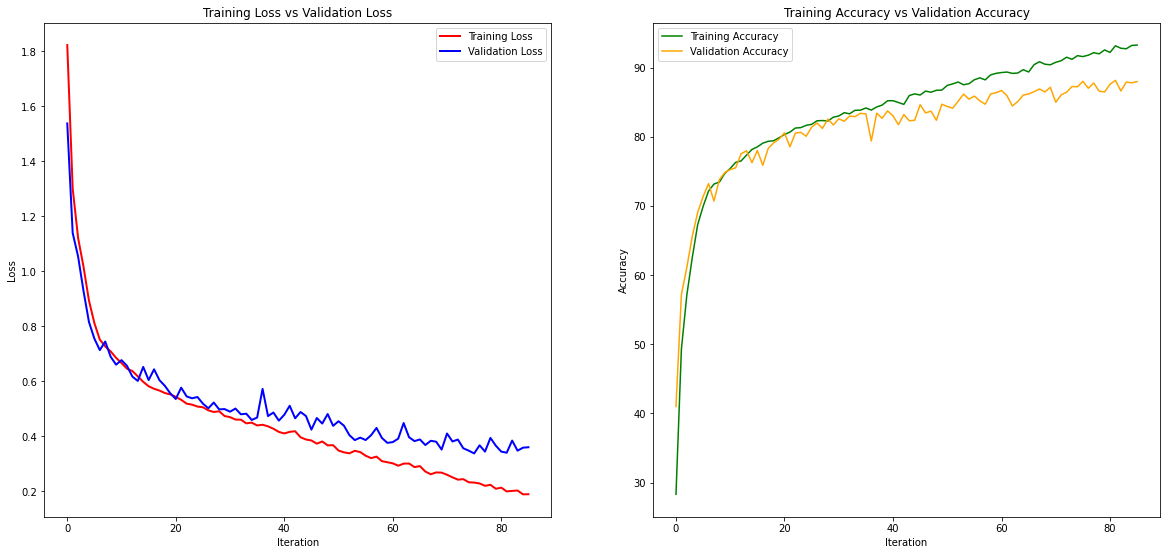

In [17]:
# ploting of loss and accuracy on the training and validation sets.
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot([i for i, _ in train_acc],linewidth = 2,color = "r",label='Training Loss')
plt.plot([i for i,_ in val_acc],linewidth = 2, color = "b",label='Validation Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.subplot(2,2,2)
plt.plot([j for _,j in train_acc],color = "green", label = 'Training Accuracy')
plt.plot([j for _,j in val_acc],color = "orange", label = 'Validation Accuracy')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.show()

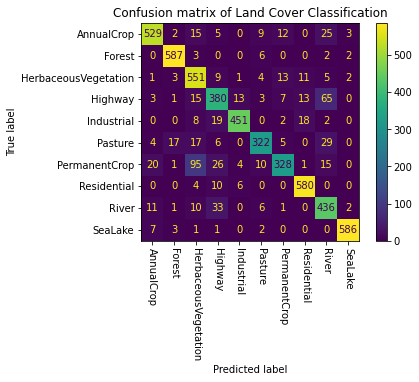

In [18]:
# Plot the confusion matrix heatmap of the test set.
classes = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]
conf_mtrx = confusion_matrix(test_target, pred_test, labels=[0,1,2,3,4,5,6,7,8,9])
ConfusionMatrixDisplay(confusion_matrix=conf_mtrx,display_labels=classes).plot()
plt.xticks(rotation=270)
plt.title('Confusion matrix of Land Cover Classification')
plt.show()